In [4]:
import matplotlib.pyplot as plt
plt.style.use(['classic'])
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from astropy.io import fits
from scipy import stats
from scipy.stats import binned_statistic
from scipy.linalg import block_diag,eigh
plt.rcParams['font.family']='stixgeneral'
plt.rcParams.update({'font.size':16})
from astropy.io import fits
import ebf
import pdb
from mpl_toolkits.mplot3d import Axes3D
from astropy.coordinates import (CartesianRepresentation,CartesianDifferential)
from astropy.coordinates import Galactic
from astropy import units as u1
from astropy.coordinates import SkyCoord

/Users/Jenny/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Jenny/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Jenny/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Running a galaxia simulation for halo17 with mag ranging from 14-20 mag, r < 1000 kpc, fsample 0.1, popID10.

In [5]:
data=ebf.read('halo17'+'.ebf') #reads in ebf file for galaxia output
df=pd.DataFrame() #creates empty pandas DataFrame
   
keys=data.keys() #creates list of keys for the ebf file
    

In [27]:
def make_csv(data_name, deg,num): #string, float (rotation angle in degrees)
    import ebf
    import pandas as pd
    import numpy as np


    rot=deg*np.pi/180. #angle in radians

    data=ebf.read(data_name+'.ebf') #reads in ebf file for galaxia output
    df=pd.DataFrame() #creates empty pandas DataFrame
   
    keys=data.keys() #creates list of keys for the ebf file
    
    #print (keys)
    #for ii in range(1,len(list(data.keys()))): #for each list in the ebf file, create a dataframe column with that key as a column name
       # s=pd.Series(data[name])
        #print (s)
        
        #df[list(data.keys())[ii]]=data[list(data.keys())[ii]]
        #print (s)
    index = range(0,len(data['smass']),1)
    indexi = np.random.choice(index, num, replace=False)
    df['smass']=data['smass'][indexi]
    
    df['age']=data['age'][indexi]
    df['rad']= data['rad'][indexi]
    
    df['mag0']= data['mag0'][indexi]
    df['mag1']= data['mag1'][indexi]
    df['mag2']= data['mag2'][indexi]
    df['popid']= data['popid'][indexi]
    df['satid']= data['satid'][indexi]
    #df['fieldid']=data['fieldid']
    #df['partid']=data['partid']
    #df['center']=data['center']
    df['lum']= data['lum'][indexi]
    df['teff']= data['teff'][indexi]
       
    #set original output positions and velocities as xx_0. These are in the unrotated frame where x-axis does not always point to galactic center
    df['glon_0']= data['glon'][indexi]
    df['glat_0']= data['glat'][indexi]
    df['px_0']= data['px'][indexi]
    df['py_0']= data['py'][indexi]
    df['pz_0']= data['pz'][indexi]
    df['vx_0']= data['vx'][indexi]
    df['vy_0']= data['vy'][indexi]  
    df['vz_0']= data['vz'][indexi]
    
    
    
    
    
    #print (df['glon_0'],df['glon'])

    #set outputs by rotating so x-axis points to galactic center
    df['glon']=(df['glon_0']-deg)%360
    df['glat']=df['glat_0']
    df['px']=df['px_0']*np.cos(rot)+df['py_0']*np.sin(rot)
    df['py']=-df['px_0']*np.sin(rot)+df['py_0']*np.cos(rot)
    df['pz']=df['pz_0']
    df['vx']=df['vx_0']*np.cos(rot)+df['vy_0']*np.sin(rot)
    df['vy']=-df['vx_0']*np.sin(rot)+df['vy_0']*np.cos(rot)
    df['vz']=df['vz_0']
    
    
    
    #set original center values
    o_cen=np.full(len(df['glon']), np.nan)
 
    o_cen[0:6]=[-8.0, 0.0, 0.015, 11.1, 239.08, 7.25]
    df['orig_center']=o_cen

    df.to_csv(data_name+'.csv', index=False) #save as CSV with same base name that can be opened in python 3
    return df



In [47]:
testd = make_csv('halo17', 0,30000)

In [7]:
len(testd['rad'])

14828361

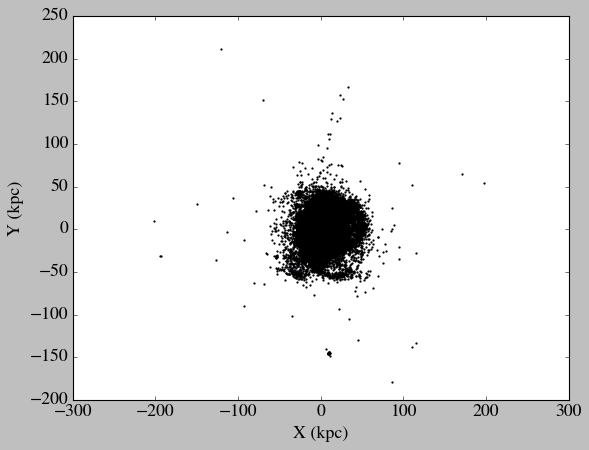

In [48]:
#plotting the x, y position for the selected 30000 sample

plt.scatter(testd['px'],testd['py'],s=1)
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.show()

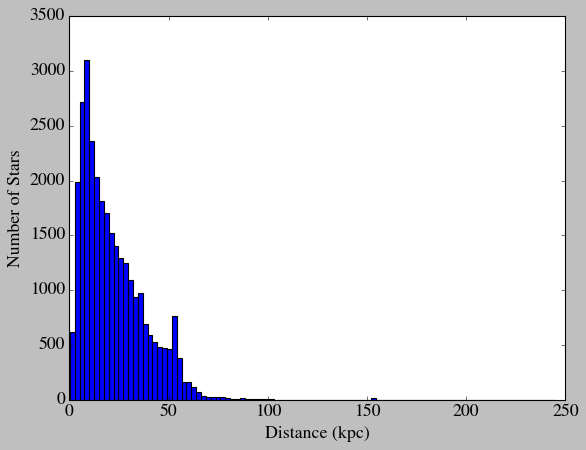

In [94]:
#histogram for the radius distribution 

plt.hist(testd['rad'],bins=100)
plt.xlabel('Distance (kpc)')
plt.ylabel('Number of Stars')
plt.show()

In [49]:
def get_coord_obj_rot(data): #pandas DataFrame
    import astropy
    import astropy.coordinates as coord
    import astropy.units as u
    import numpy as np
    x=data['x'].values#full sets in heliocentric coords
    y=data['y'].values
    z=data['z'].values
    vx=data['vx'].values
    vy=data['vy'].values
    vz=data['vz'].values
    
    v_sun_gc=[data['orig_center'][3], data['orig_center'][4], data['orig_center'][5]] #galactocentric sun coordinates, based on original heliocentric x-axis aligned with galactocentric X-axis

    gal=coord.SkyCoord(u=x*u.kpc, v=y*u.kpc, w=z*u.kpc, #galactic frame cartesian coordinate object
                       U=vx*u.km/u.s, V=vy*u.km/u.s, W=vz*u.km/u.s, frame='galactic', 
                       representation_type='cartesian', differential_type='cartesian')
    gal.representation_type='spherical' #change type to spherical (l, b, proper motions, rad vel, etc)
    gal.differential_type=coord.representation.SphericalCosLatDifferential

    return gal #return coordinate object

#TURNS A DATAFRAME OF STARS INTO ASTROPY COORDINATE OBJECT, GALACTIC FRAME (HELIOCENTRIC X-AXIS TO GC), TAKING INTO ACCOUNT THE SOLAR REFLEX MOTION
def get_coord_obj_rot_gsr(data):
    import astropy
    import astropy.coordinates as coord
    import astropy.units as u
    import numpy as np
    x=data['px'].values#full sets in heliocentric coords
    y=data['py'].values
    z=data['pz'].values
    vx=data['vx'].values
    vy=data['vy'].values
    vz=data['vz'].values
    # v_sun_gl=[data['center'][3], data['center'][4], data['center'][5]]
    v_sun_gc=[11.1, 239.08, 7.25] #galactocentric sun coordinates
    v_sun=coord.CartesianDifferential(v_sun_gc*u.km/u.s) #turn into a coordinate cartesian differential
    
   
    gal=coord.SkyCoord(u=x*u.kpc, v=y*u.kpc, w=z*u.kpc,
                       U=(vx+v_sun_gc[0])*u.km/u.s, V=(vy+v_sun_gc[1])*u.km/u.s, W=(vz+v_sun_gc[0])*u.km/u.s, frame='galactic',
                       representation_type='cartesian', differential_type='cartesian') #adds solar velocity to star velocity for calculating gsr frame parameters
    print (gal)
    gal.representation_type='spherical' #convert to spherical representation (l, b, distance)
    
    gal.differential_type=coord.representation.SphericalCosLatDifferential #convert differentials to spherical cos lat (proper motions, radial velocity)
                       
    return gal

#takes an angle and returns corresponding angle within limits. If no minparam give, returns angle between (0,2*pi)/(0,360)
#if minval is given returns angle between (minval, minval+2*pi)/(minval, minval+360). Ex if minval=-pi, range will be (-pi, pi)
def limrange(angle, *minparam, **degflag):    #float, float, bool (deg=True/False)
    import numpy as np
    if len(minparam) == 0: minval = 0.0
    else: minval = minparam[0]
    
    if ('deg' in degflag):
        newangle = (angle-minval)%(360.0)+minval
    else:   
        newangle = (angle-minval)%(2.0*np.pi)+minval
        
    return newangle

#add radial velocity, l, b, dist, proper motions, v_gsr, pm_gsr, v_t, v_t_gsr, dist modulus to CSV
def rv_csv(halo, field, deg): #string, string, int
    import pandas as pd
    import numpy as np
    #NAME OF CSV FILE
    if deg%1==0: #if deg is integer use make string
        d=str(int(deg))
    else:
        d="{0:.2f}".format(deg) #else round to 2 decimals and make string
    data_name=halo+'/'+d+'/'+field+'/'+halo+'_'+field+'_'+d
    #OPEN CSV
    data=pd.read_csv(data_name+'.csv')
    #GALACTOCENTRIC SOLAR VELOCITY WITH SUN ON X-AXIS
    v_sun_gc=[11.1, 239.08, 7.25]
    #CREATE ASTROPY COORD OBJECT
    gal=get_coord_obj_rot(data)
    gal_gsr=get_coord_obj_rot_gsr(data)
    #ASSIGN TO DATAFRAME
    data=data.assign(l_coord=gal.l.degree)
    data=data.assign(b_coord=gal.b.degree)
    data=data.assign(pm_l_cosb=gal.pm_l_cosb)
    data=data.assign(pm_b=gal.pm_b)
    data=data.assign(pm_mag=np.sqrt(np.add(np.square(data.pm_b),np.square(data.pm_l_cosb))))
    data=data.assign(r_v=gal.radial_velocity)
    data=data.assign(dist=gal.distance)
    data=data.assign(dm=5.*np.log10(gal.distance.value*1000.)-5.)
    data=data.assign(v_l=4.74047*gal.pm_l_cosb*gal.distance)
    data=data.assign(v_b=4.74047*gal.pm_b*gal.distance)
    data=data.assign(v_t=np.sqrt(np.add(np.square(data.v_l),np.square(data.v_b))))
    data=data.assign(pm_l_cosb_gsr=gal_gsr.pm_l_cosb)
    data=data.assign(pm_b_gsr=gal_gsr.pm_b)
    data=data.assign(pm_mag_gsr=np.sqrt(np.add(np.square(data.pm_b_gsr),np.square(data.pm_l_cosb_gsr))))
    data=data.assign(v_gsr=gal_gsr.radial_velocity)
    data=data.assign(v_l_gsr=4.74047*gal_gsr.pm_l_cosb*gal_gsr.distance)
    data=data.assign(v_b_gsr=4.74047*gal_gsr.pm_b*gal_gsr.distance)
    data=data.assign(v_t_gsr=np.sqrt(np.add(np.square(data.v_l_gsr),np.square(data.v_b_gsr))))
    #SAVE NEW CSV WITH SAME NAME TO REPLACE
    data.to_csv(data_name+'.csv', index=False)
    



In [50]:
rad_t = get_coord_obj_rot_gsr(testd)

<SkyCoord (Galactic): (u, v, w) in kpc
    [( 0.12917967, -4.25242615,  -4.0838947),
     (13.29734612, 21.57146072,   2.6833677),
     (28.37368202, 24.7208786 ,   2.7778475), ...,
     (-4.15028381, -7.47286129,   6.443194 ),
     (45.49467087, 18.43705559, -16.797602 ),
     ( 1.08315659, 10.16897678,  22.611038 )]
 (U, V, W) in km / s
    [( 94.15579376,    0.28567322,  -7.777666),
     (112.18446503,  270.92139824, 145.75784 ),
     (119.23890076,  251.41137512,  95.56992 ), ...,
     (  4.62044487,   90.21739014, 356.5664  ),
     (137.9888855 , -156.03709595,  64.48104 ),
     (-11.44670715,  241.24634226, 179.14928 )]>


In [51]:
rad_t

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    [(271.73998895, -43.82863501,  5.8972885 ),
     ( 58.3489767 ,   6.04463463, 25.48230354),
     ( 41.06436235,   4.22166437, 37.73465393), ...,
     (240.95304695,  37.00771482, 10.70435703),
     ( 22.06061995, -18.89040814, 51.88303691),
     ( 83.92001938,  65.66375308, 24.81613116)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [( 3.36676622, -0.1369597 ,   7.24254541),
     ( 0.38631634,  0.94755583, 303.23192096),
     ( 0.62180436,  0.42785413, 261.39991722), ...,
     (-0.78361689,  6.57346133, 149.85190553),
     (-0.79869904,  0.33924915,  44.67293382),
     ( 0.3139602 , -1.22103721, 261.58714975)]>

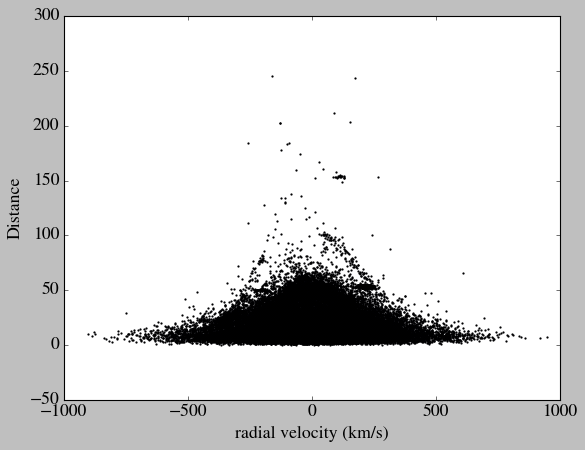

In [54]:
#plotting distance versus vrad (compared to Bullock 2005)

plt.scatter(rad_t.radial_velocity/u1.km*u1.s,testd['rad'],s=1,c='b')
plt.ylabel('Distance')
plt.xlabel('radial velocity (km/s)')
plt.xlim(-1000,1000)
plt.show()

# Velocity dispersion

In [55]:
# Function for calculating the space separation and the velocity difference in each shell

def v_diff(spaces,data,interval):
    
    '''
        :param spaces: Scale for space sparation   
        :param data: The orginal dataset
        :param interval: raidal space interval for the shell of calculating the space separation
   
        
    '''
    
    vdiffh = []
    rlim = []
    num = []
    spect = []
    kk=0
    for ii in range(int(20),int(80),interval):
        
        rlim.append(ii)
        zmin = ii
        zmax = ii+interval
        dfx=pd.DataFrame()
        dfxf = pd.DataFrame()
        dfx['x']=data['x'][ (zmin < data['r'] ) & (data['r'] < zmax ) ]
        dfx['y']=data['y'][ (zmin < data['r'] ) & (data['r'] < zmax ) ]
        dfx['z']=data['z'][ (zmin < data['r'] ) & (data['r'] < zmax ) ]
        dfx['Vgal']= data['Vgal'][ (zmin < data['r'] ) & (data['r'] < zmax ) ]
        dfx['SimbadName']= data['SimbadName'][ (zmin < data['r'] ) & (data['r'] < zmax )]
       
        dfx['r']= data['r'][ (zmin < data['r'] ) & (data['r'] < zmax )]
        dia=[]
        vdiff = []
        spacedt = []
        num.append(len(dfx['r']))
        dfx2 = dfx.sort_values(by=['SimbadName'])
        
        indexp = [x for x in data.index if x not in dfx2.index]
        indexs = np.append(np.array(dfx2.index),np.array(indexp))
        
        dfxf = data.loc[indexs]
        
        
        #print (dfx2['r'])
        k = Comp(dfx2['x'],dfx2['y'],dfx2['z'],dfx2['Vgal'])
        k2 = Comp(dfxf['x'],dfxf['y'],dfxf['z'],dfxf['Vgal'])
        
        print (k.rv,k2.rv)
        #vsort = k.rv[np.argsort(dfx['r'])]
        #xsort = k.x[np.argsort(dfx['r'])]
        #ysort = k.y[np.argsort(dfx['r'])]
        #zsort = k.z[np.argsort(dfx['r'])]
       # print ('v1',k.rv,k.x)
        #print ('v2',k2.rv,k2.x)
        
        
            
        #calculating the velocity difference and space separation for each shell
        for jj in range(0,len(k.rv)): 
            
            #print (k.rv,k2.rv)
           
            
            vi = np.repeat(k.rv[jj],len(k2.rv))
            xi = np.repeat(k.x[jj],len(k2.rv))
            yi = np.repeat(k.y[jj],len(k2.rv))
            zi = np.repeat(k.z[jj],len(k2.rv))
            print (len(vi))
        
            diffv = (vi - k2.rv)**2
            diffx = (xi - k2.x)**2
            diffy = (yi - k2.y)**2
            diffz = (zi - k2.z)**2
        
        
            diff = diffv+diffx+diffy+diffz
            spaced = diffx+diffy+diffz
          
            
            dia.append(diff)
            vdiff.append(vi - k2.rv)
            spacedt.append(np.sqrt(spaced))
        #print (len(vdiff))
        
        
        
        
        #diaf = np.array(dia)[np.triu_indices(len(dfx['r']),1)]
        vdiffto = np.array(vdiff)[np.triu_indices(len(k.rv),1)]
        specdto = np.array(spacedt)[np.triu_indices(len(k.rv),1)]
         
        spect.append(specdto)
        
        print (len(vdiffto),len(specdto))
        
        vdiffh.append(vdiffto[specdto < spaces[kk]])
       
        kk=kk+1
        
    return rlim,vdiffh,num,spect
        
        

In [56]:
zmin = 10
zmax = 100
zlim = 4.

In [57]:
vral = rad_t.radial_velocity/u1.km*u1.s

In [93]:
# cutting r and z > 20 & r < 60 kpc stars 
df1=pd.DataFrame()
df2=pd.DataFrame()
df3 = pd.DataFrame()
df1['x']=testd['px'][ (zmin < testd['rad'] ) & (testd['rad'] < zmax ) ]
df1['y']=testd['py'][ (zmin < testd['rad'] ) & (testd['rad'] < zmax ) ]
df1['z']=testd['pz'][ (zmin < testd['rad'] ) & (testd['rad'] < zmax ) ]
df1['Vgal']= vral[ (zmin < testd['rad'] ) & (testd['rad'] < zmax ) ]
df1['r']= testd['rad'][ (zmin < testd['rad']  ) & (testd['rad']  < zmax )]
df1['index']= np.arange(0,len(df1['r']),1)
#print (df1['index'])
df2['r']=df1['r'][(np.absolute(df1['z']) > zlim)]
df2['x']=df1['x'][(np.absolute(df1['z']) > zlim)]
df2['y']=df1['y'][(np.absolute(df1['z']) > zlim) ]
df2['z']=df1['z'][(np.absolute(df1['z']) > zlim)]
df2['Vgal']= df1['Vgal'][(np.absolute(df1['z']) > zlim)]
df2['index']= np.arange(0,len(df2['r']),1)

In [72]:
df3 = df2.sort_values(by=['index'])

In [73]:
#class for the input of the correlation function 
class Comp:
    def __init__(self,x,y,z,rv):
        '''
        class for the input of the correlation function 
        :param x: x position for the target 
        :param y: y position for the target 
        :param z: z position for the target
        :param rv: radial velocity for the target 
        
        '''

        self.x = np.array(x)
        self.y = np.array(y)
        self.z = np.array(z)
        self.rv = np.array(rv)



In [83]:
# Function for calculating the space separation and the velocity difference in each shell

def v_diff(spaces,data,interval):
    
    '''
        :param spaces: Scale for space sparation   
        :param data: The orginal dataset
        :param interval: raidal space interval for the shell of calculating the space separation
   
        
    '''
    
    vdiffh = []
    rlim = []
    num = []
    spect = []
    kk=0
    for ii in range(int(20),int(100),interval):
        
        rlim.append(ii)
        zmin = ii
        zmax = ii+interval
        dfx=pd.DataFrame()
        dfxf = pd.DataFrame()
        dfx['x']=data['x'][ (zmin < data['r'] ) & (data['r'] < zmax ) ]
        dfx['y']=data['y'][ (zmin < data['r'] ) & (data['r'] < zmax ) ]
        dfx['z']=data['z'][ (zmin < data['r'] ) & (data['r'] < zmax ) ]
        dfx['Vgal']= data['Vgal'][ (zmin < data['r'] ) & (data['r'] < zmax ) ]
        dfx['index']= np.arange(0,len(dfx['x']),1)
       
        dfx['r']= data['r'][ (zmin < data['r'] ) & (data['r'] < zmax )]
        dia=[]
        vdiff = []
        spacedt = []
        num.append(len(dfx['r']))
        dfx2 = dfx.sort_values(by=['index'])
        
        indexp = [x for x in data.index if x not in dfx2.index]
        indexs = np.append(np.array(dfx2.index),np.array(indexp))
        
        dfxf = data.loc[indexs]
        
        
        #print (dfx2['r'])
        k = Comp(dfx2['x'],dfx2['y'],dfx2['z'],dfx2['Vgal'])
        k2 = Comp(dfxf['x'],dfxf['y'],dfxf['z'],dfxf['Vgal'])
        
        #print (k.rv,k2.rv)
        #vsort = k.rv[np.argsort(dfx['r'])]
        #xsort = k.x[np.argsort(dfx['r'])]
        #ysort = k.y[np.argsort(dfx['r'])]
        #zsort = k.z[np.argsort(dfx['r'])]
       # print ('v1',k.rv,k.x)
        #print ('v2',k2.rv,k2.x)
        
        
            
        #calculating the velocity difference and space separation for each shell
        for jj in range(0,len(k.rv)): 
            
            #print (k.rv,k2.rv)
           
            
            vi = np.repeat(k.rv[jj],len(k2.rv))
            xi = np.repeat(k.x[jj],len(k2.rv))
            yi = np.repeat(k.y[jj],len(k2.rv))
            zi = np.repeat(k.z[jj],len(k2.rv))
            
        
            diffv = (vi - k2.rv)**2
            diffx = (xi - k2.x)**2
            diffy = (yi - k2.y)**2
            diffz = (zi - k2.z)**2
        
        
            diff = diffv+diffx+diffy+diffz
            spaced = diffx+diffy+diffz
          
            
            dia.append(diff)
            vdiff.append(vi - k2.rv)
            spacedt.append(np.sqrt(spaced))
        #print (len(vdiff))
        
        
        
        
        #diaf = np.array(dia)[np.triu_indices(len(dfx['r']),1)]
        vdiffto = np.array(vdiff)[np.triu_indices(len(k.rv),1)]
        specdto = np.array(spacedt)[np.triu_indices(len(k.rv),1)]
         
        spect.append(specdto)
        
        #print (len(vdiffto),len(specdto))
        
        vdiffh.append(vdiffto[specdto < spaces[kk]])
       
        kk=kk+1
        
    return rlim,vdiffh,num,spect
        
        

In [89]:
space_sep = [8,10,12,14,16,18,20,22,24,26]
rlim,test1,num,sep = v_diff(space_sep,df3,10)

[241.08774277 157.28792851 -28.50951411 ... 135.38578063 266.25409713
 261.58714975] [241.08774277 157.28792851 -28.50951411 ... -99.55522178 149.85190553
  44.67293382]
[-134.60826464  165.62235413   -0.31726534 ... -208.86212571  230.00000672
  233.92292092] [-134.60826464  165.62235413   -0.31726534 ...  149.85190553   44.67293382
  261.58714975]
[  -4.42928137 -136.93422178 -124.26782773 ...   80.31435771 -154.10715679
 -102.280129  ] [  -4.42928137 -136.93422178 -124.26782773 ...  149.85190553   44.67293382
  261.58714975]
[ 58.27905465  42.84755544 -71.94403606 ...  60.98452744 -95.86384826
  44.67293382] [ 58.27905465  42.84755544 -71.94403606 ... 266.25409713 149.85190553
 261.58714975]
[-6.62445659e+01  9.69328421e+01 -6.30618384e+01 -8.41897984e+01
  1.62239262e+02 -2.20500252e+02  3.38980131e+01  3.62503302e+01
 -1.51052769e+02 -2.25114062e+00  2.55670615e+00 -6.04867778e+01
 -6.57278876e+01  7.92030529e+01  4.96047915e+01 -2.27153489e+02
  5.15739543e+01 -3.16334621e+01 -2.

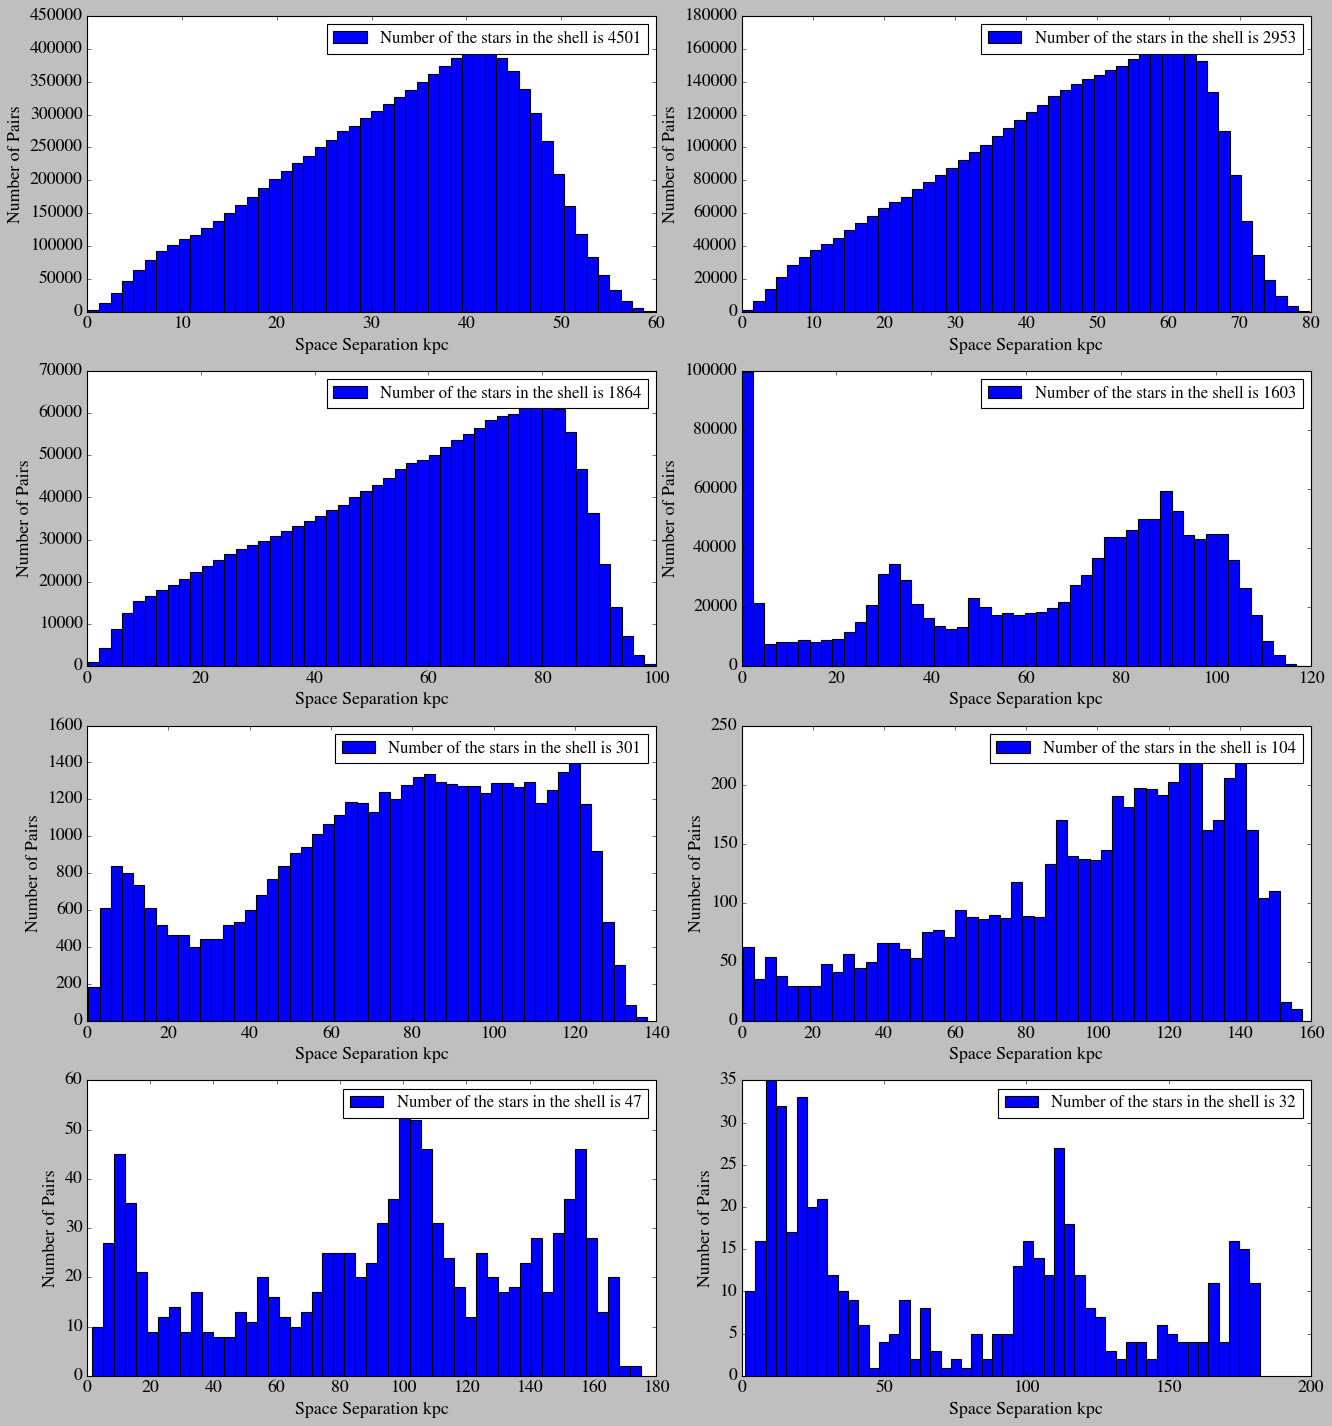

In [95]:
#Plotting the histogram for the space separation for each shell (number of the stars in the shell labelled)

fig, ax = plt.subplots(4, 2, figsize=(18, 20), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=False, sharey=False)

fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
k = 0
    
degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
for index in range(ax.shape[0]):
    for jndex in range(ax.shape[1]):
        ax[index][jndex].hist(sep[k], bins=50, label='Number of the stars in the shell is '+str(num[k]))
            

        ax[index][jndex].set_xlabel('Space Separation kpc')
        ax[index][jndex].set_ylabel('Number of Pairs')
        ax[index][jndex].legend( prop={'size': 15})
        
            
            
        k = k + 1
            
plt.show()

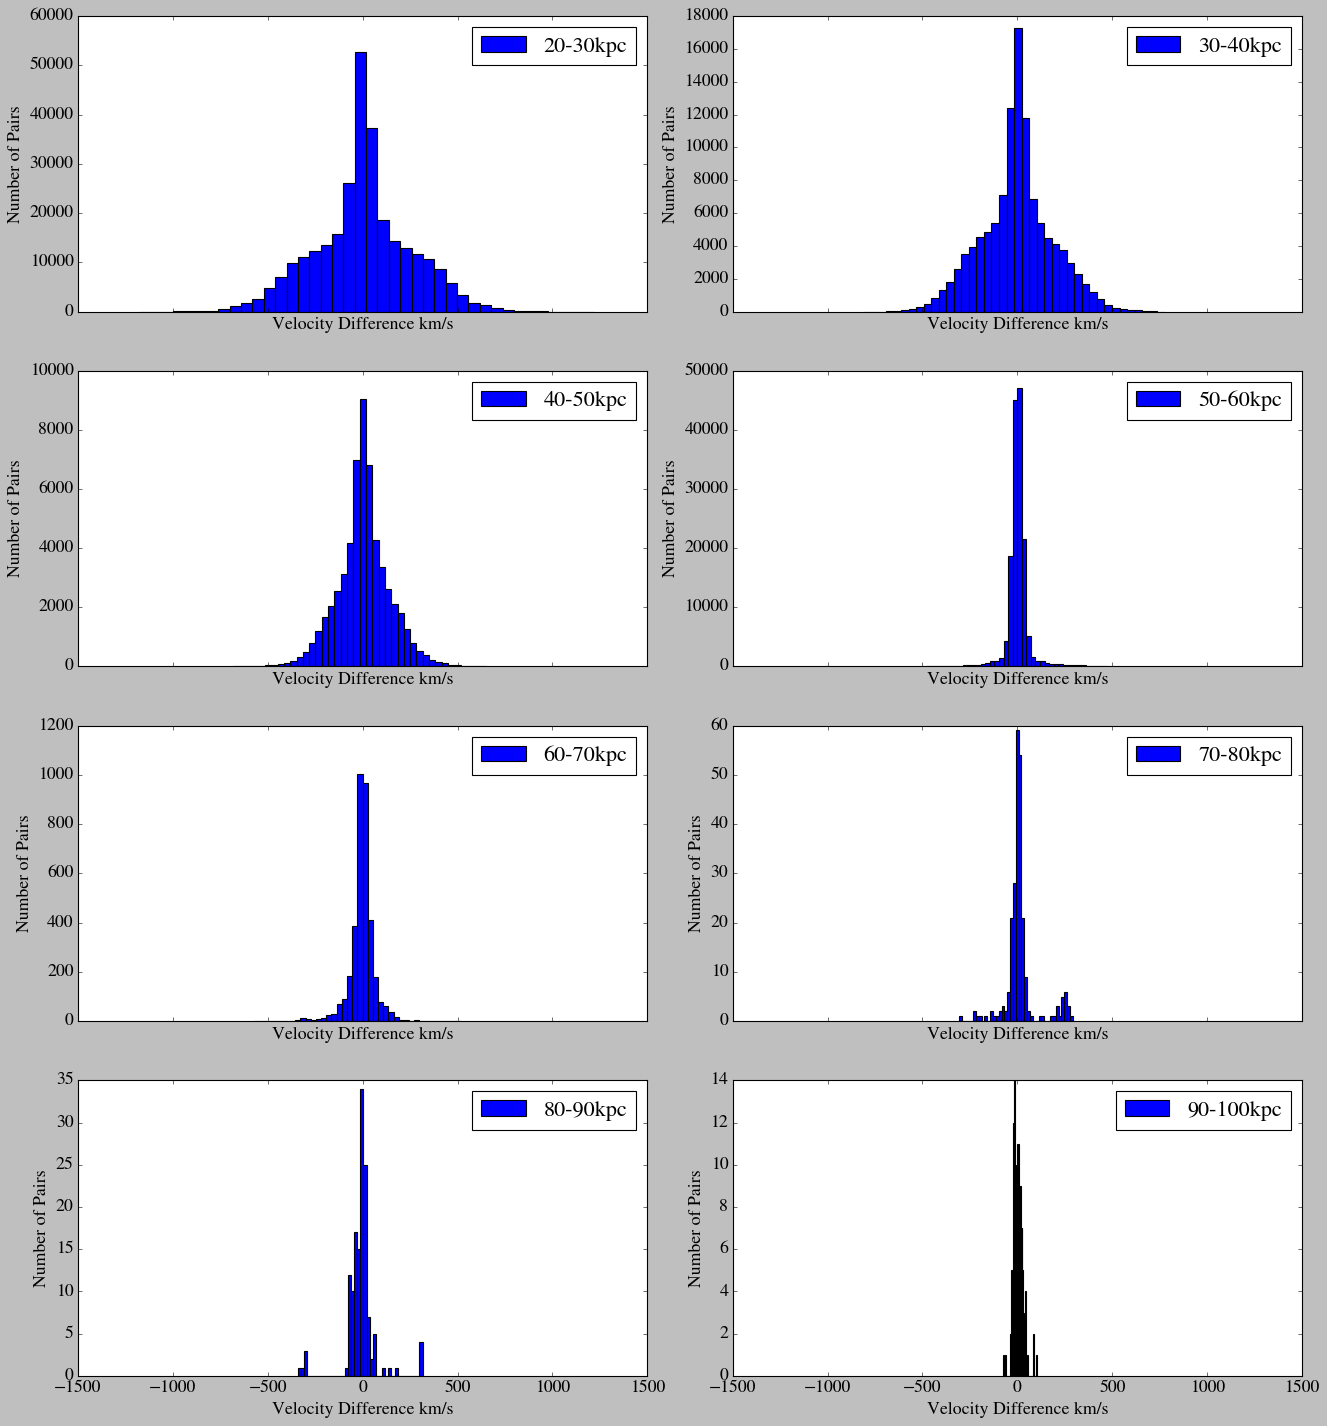

In [91]:
fig, ax = plt.subplots(4, 2, figsize=(18, 20), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True, sharey=False)

fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
k = 0
    
degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
for index in range(ax.shape[0]):
    for jndex in range(ax.shape[1]):
        ax[index][jndex].hist(test1[k], bins=40, label=str(int(rlim[k])) +'-'+ str(int(rlim[k]+10))+'kpc')
            

        ax[index][jndex].set_xlabel('Velocity Difference km/s')
        ax[index][jndex].set_ylabel('Number of Pairs')
        ax[index][jndex].legend( prop={'size': 20})
        
            
            
        k = k + 1
            
plt.show()